(464, 464, 463) [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


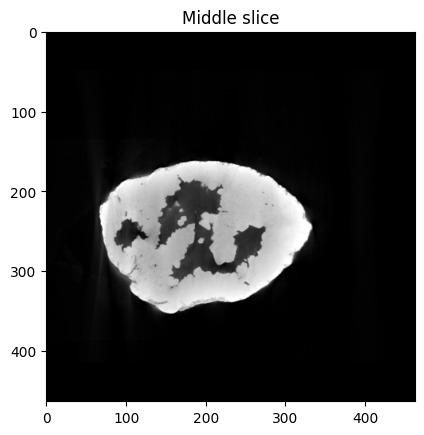

In [18]:
import nrrd
import numpy as np
import matplotlib.pyplot as plt

data, header = nrrd.read("data/geode.nrrd")
print(data.shape, header["space directions"])

plt.imshow(data[data.shape[0] // 2], cmap='gray')
plt.title("Middle slice")
plt.show()


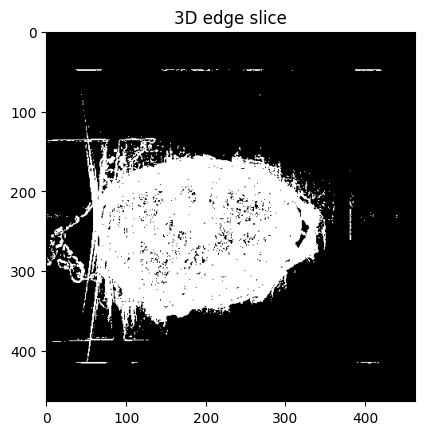

In [12]:
from scipy import ndimage

edges = ndimage.generic_gradient_magnitude(data.astype(float), ndimage.sobel)
edges = (edges > edges.mean())  # binary boundary mask
plt.imshow(edges[data.shape[0]//2], cmap='gray')
plt.title("3D edge slice")
plt.show()

In [14]:
!pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --------- ------------------------------ 2.9/12.8 MB 15.2 MB/s eta 0:00:01
   ------------------ --------------------- 5.8/12.8 MB 15.3 MB/s eta 0:00:01
   ------------------------- -------------- 8.1/12.8 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 16.4 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 15.7 MB/s  0:00:00

   ---------------------------------------- 0/4 [tifffile]
   -------------------- ------------------- 2/4 [imageio]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3/4 [scikit-image]
   ------------------------------ --------- 3

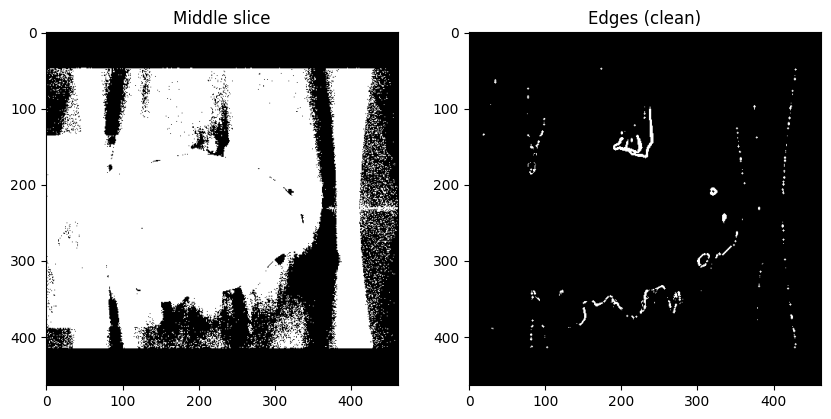

In [19]:
import nrrd, numpy as np
from scipy import ndimage as ndi
from skimage import filters, measure, morphology

# --- 0) Load ---
vol, hdr = nrrd.read("data/geode.nrrd")
vol = vol.astype(np.float32)

# --- 1) Clip & normalize (robust to outliers) ---
lo, hi = np.percentile(vol, (25, 75))   # adjust if needed
vol = np.clip(vol, lo, hi)
vol = (vol - vol.min()) / (vol.max() - vol.min() + 1e-8)

# --- 2) Denoise a bit (3D Gaussian) ---
vol_s = ndi.gaussian_filter(vol, sigma=1.0)

# --- 3) Background removal: object ROI ---
t = filters.threshold_otsu(vol_s)
roi = vol_s > t                          # foreground
# keep only the largest connected component
lab = measure.label(roi)
if lab.max() > 0:
    counts = np.bincount(lab.ravel())
    counts[0] = 0
    roi = (lab == np.argmax(counts))

roi = morphology.binary_closing(roi, morphology.ball(2))
roi = ndi.binary_fill_holes(roi)

# --- 4) Gradient magnitude inside ROI (smoothed) ---
grad = ndi.gaussian_gradient_magnitude(vol_s, sigma=1.0)
grad *= roi                              # zero out background

# --- 5) Robust edge threshold (e.g., 95th percentile in ROI) ---
thr = np.percentile(grad[roi], 95)       # try 92–98 depending on sharpness
edge_mask = (grad >= thr)

# --- 6) Clean up edges (optional) ---
edge_mask = morphology.remove_small_objects(edge_mask, 64)
edge_mask = morphology.binary_opening(edge_mask, morphology.ball(1))

# --- 7) Quick slice view (same center slice as before) ---
import matplotlib.pyplot as plt
z = vol.shape[0] // 2
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(vol[z], cmap='gray'); ax[0].set_title('Middle slice')
ax[1].imshow(edge_mask[z], cmap='gray'); ax[1].set_title('Edges (clean)')
plt.show()
